In [1]:
import os
import argparse
import logging
import multiprocessing as mp
from functools import partial

import yaml
import numpy as np
import pandas as pd
import trackml.dataset # https://github.com/LAL/trackml-library 

from datasets.graph_utils import Graph, save_graphs

In [2]:
# Transformed preprocessing.py into a class

def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

class Preprocessor:
    def __init__(self, evtid, vlids, pt_min, phi_slope_max, z0_max, n_phi_sections, n_eta_sections, eta_range, phi_range):
        # load_event('/Users/Eden/Desktop/Datasets/train_100_events/event000001000-hits')
        # The original preprocessing module only uses hits data.
        self.evtid = evtid
        self.hits, self.particles, self.truth = trackml.dataset.load_event(evtid, parts=['hits', 'particles', 'truth'])
        self.vlids  = vlids
        self.pt_min = pt_min
        self.phi_slope_max = phi_slope_max
        self.z0_max = z0_max
        self.n_phi_sections = n_phi_sections
        self.n_eta_sections = n_eta_sections
        self.eta_range = eta_range
        self.phi_range = phi_range
        
    def select_segments(self, hits1, hits2):
        """
        Construct a list of selected segments from the pairings
        between hits1 and hits2, filtered with the specified
        phi slope and z0 criteria.
        Returns: pd DataFrame of (index_1, index_2), corresponding to the
        DataFrame hit label-indices in hits1 and hits2, respectively.
        """
        # Start with all possible pairs of hits
        keys = ['evtid', 'r', 'phi', 'z']
        hit_pairs = hits1[keys].reset_index().merge(
            hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
        # Compute line through the points
        dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
        dz = hit_pairs.z_2 - hit_pairs.z_1
        dr = hit_pairs.r_2 - hit_pairs.r_1
        phi_slope = dphi / dr
        z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
        # Filter segments according to criteria
        good_seg_mask = (phi_slope.abs() < self.phi_slope_max) & (z0.abs() < self.z0_max)
        return hit_pairs[['index_1', 'index_2']][good_seg_mask]
    
    def construct_graph(self, hits, layer_pairs, feature_names, feature_scale):
        """Construct one graph (e.g. from one event)"""
        # Loop over layer pairs and construct segments
        layer_groups = hits.groupby('layer')
        segments = []
        for (layer1, layer2) in layer_pairs:
            # Find and join all hit pairs
            try:
                hits1 = layer_groups.get_group(layer1)
                hits2 = layer_groups.get_group(layer2)
            # If an event has no hits on a layer, we get a KeyError.
            # In that case we just skip to the next layer pair
            except KeyError as e:
                logging.info('skipping empty layer: %s' % e)
                continue
            # Construct the segments
            segments.append(self.select_segments(hits1, hits2))
        # Combine segments from all layer pairs
        segments = pd.concat(segments)
    
        # Prepare the graph matrices
        n_hits = hits.shape[0]
        n_edges = segments.shape[0]
        X = (hits[feature_names].values / feature_scale).astype(np.float32)
        Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)
        Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)
        y = np.zeros(n_edges, dtype=np.float32)
    
        # We have the segments' hits given by dataframe label,
        # so we need to translate into positional indices.
        # Use a series to map hit label-index onto positional-index.
        hit_idx = pd.Series(np.arange(n_hits), index=hits.index)
        seg_start = hit_idx.loc[segments.index_1].values
        seg_end = hit_idx.loc[segments.index_2].values
    
        # Now we can fill the association matrices.
        # Note that Ri maps hits onto their incoming edges,
        # which are actually segment endings.
        Ri[seg_end, np.arange(n_edges)] = 1
        Ro[seg_start, np.arange(n_edges)] = 1
        # Fill the segment labels
        pid1 = hits.particle_id.loc[segments.index_1].values
        pid2 = hits.particle_id.loc[segments.index_2].values
        y[:] = (pid1 == pid2)
        # Return a tuple of the results
        return Graph(X, Ri, Ro, y)

    def select_hits(self, hits, truth, particles):
        # Barrel volume and layer ids
        n_det_layers = len(self.vlids)
        # Select barrel layers and assign convenient layer number [0-9]
        vlid_groups = hits.groupby(['volume_id', 'layer_id'])
        hits = pd.concat([vlid_groups.get_group(self.vlids[i]).assign(layer=i)
                          for i in range(n_det_layers)])
        # Calculate particle transverse momentum
        pt = np.sqrt(particles.px**2 + particles.py**2)
        # True particle selection.
        # Applies pt cut, removes all noise hits.
        particles = particles[pt > self.pt_min]
        truth = (truth[['hit_id', 'particle_id']]
                 .merge(particles[['particle_id']], on='particle_id'))
        # Calculate derived hits variables
        r = np.sqrt(hits.x**2 + hits.y**2)
        phi = np.arctan2(hits.y, hits.x)
        # Select the data columns we need
        hits = (hits[['hit_id', 'z', 'layer']]
                .assign(r=r, phi=phi)
                .merge(truth[['hit_id', 'particle_id']], on='hit_id'))
        # display(hits[hits['particle_id']==4503668346847232])
        # display(hits.groupby(['particle_id', 'layer']).count())
        return hits
    def split_detector_sections(self, hits, phi_edges, eta_edges):
        """Split hits according to provided phi and eta boundaries."""
        hits_sections = []
        # Loop over sections
        for i in range(len(phi_edges) - 1):
            phi_min, phi_max = phi_edges[i], phi_edges[i+1]
            # Select hits in this phi section
            phi_hits = hits[(hits.phi > phi_min) & (hits.phi < phi_max)]
            # Center these hits on phi=0
            centered_phi = phi_hits.phi - (phi_min + phi_max) / 2
            phi_hits = phi_hits.assign(phi=centered_phi, phi_section=i)
            for j in range(len(eta_edges) - 1):
                eta_min, eta_max = eta_edges[j], eta_edges[j+1]
                # Select hits in this eta section
                eta = calc_eta(phi_hits.r, phi_hits.z)
                sec_hits = phi_hits[(eta > eta_min) & (eta < eta_max)]
                hits_sections.append(sec_hits.assign(eta_section=j))
        return hits_sections
    def process_event(self):
        hits = self.select_hits(self.hits, self.truth, self.particles).assign(evtid=int(self.evtid[-9:]))
    
        # Divide detector into sections
        phi_edges = np.linspace(*self.phi_range, num=self.n_phi_sections+1)
        eta_edges = np.linspace(*self.eta_range, num=self.n_eta_sections+1)
        hits_sections = self.split_detector_sections(hits, phi_edges, eta_edges)
    
        # Graph features and scale
        feature_names = ['r', 'phi', 'z']
        feature_scale = np.array([1000., np.pi / self.n_phi_sections, 1000.])
    
#       # Define adjacent layers
        n_det_layers = 10
        l = np.arange(n_det_layers)
        layer_pairs = np.stack([l[:-1], l[1:]], axis=1)
    
#       # Construct the graph
        graphs = [self.construct_graph(section_hits, layer_pairs=layer_pairs, 
                                  feature_names=feature_names, feature_scale=feature_scale) 
                                  for section_hits in hits_sections]
        return graphs
#         # Write these graphs to the output directory
#         try:
#             base_prefix = os.path.basename(prefix)
#             filenames = [os.path.join(output_dir, '%s_g%03i' % (base_prefix, i))
#                          for i in range(len(graphs))]
#         except Exception as e:
#             logging.info(e)
#         logging.info('Event %i, writing graphs', evtid)
#         save_graphs(graphs, filenames)
    

In [3]:
# Original values
#    pt_min: 0. # GeV
#    phi_slope_max: 0.0006
#    z0_max: 200 # *inconsistent with the paper should be 100
#    n_phi_sections: 8
#    n_eta_sections: 2
#    eta_range: [-5, 5]
#    phi_range=(-np.pi, np.pi)

evtstr = '../train_100_events/event000001000' 
#Need to Iterate through every event, the script will automatically pull the -hits.csv

#volume_id: numerical identifier of the detector group.
#layer_id: numerical identifier of the detector layer inside the group.
#module_id: numerical identifier of the detector module inside the layer.

# Barrel volume and layer ids
vlids_original = [(8,2), (8,4), (8,6), (8,8),
                  (13,2), (13,4), (13,6), (13,8),
                  (17,2), (17,4)]
# Reduced radius, TODO: Figure out the right volume and layer combo
vlids_reduced = [(8,2), (8,4), (8,6), (8,8),]

vlids = vlids_reduced

pt_min = 0
phi_slope_max = 0.0006 
z0_max = 200 
n_phi_sections = 8 
n_eta_sections = 2
eta_range = [-5,5]
phi_range = (-np.pi, np.pi)


preproc = Preprocessor(evtid=evtstr, vlids=vlids, pt_min=pt_min, phi_slope_max=phi_slope_max, 
                       z0_max=z0_max, n_phi_sections=n_phi_sections, n_eta_sections=n_eta_sections, 
                       eta_range=eta_range, phi_range=phi_range)

In [4]:
graphs = preproc.process_event() #Generated 16 graphs on the first event

In [5]:
import sys, os, time, datetime, csv
sys.path.append(os.path.abspath(os.path.join('.')))
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from tools import *
from tqdm import tqdm
from matplotlib.lines import Line2D

In [6]:
n_section = 8

In [7]:
def plot_cylindrical(graphs,n_section):

        #print('Plotting file: ' + filenames[0] + ' to: ' + pdf_dir)
        X, Ri, Ro, y = graphs[0]

        feats_o = X[np.where(Ri.T)[1]]
        feats_i = X[np.where(Ro.T)[1]]
        
        feats_o[:,0] = feats_o[:,0]*1000 
        feats_o[:,1] = feats_o[:,1]*np.pi/n_section
        feats_o[:,2] = feats_o[:,2]*1000  
        feats_i[:,0] = feats_i[:,0]*1000  
        feats_i[:,1] = feats_i[:,1]*np.pi/n_section
        feats_i[:,2] = feats_i[:,2]*1000  

        print('Plotting: Initial Graph colored in Cylindrical coordinates!')

        fig, ax = plt.subplots(1, 2, figsize = (10,5),sharey=True, tight_layout=True)
        cmap = plt.get_cmap('bwr_r')
        color = {0:'red',1:'blue'}

        ax[0].scatter((np.pi/8)*X[:,1], 1000*X[:,0], c='k')
        for j in range(y.shape[0]):
            seg_args = dict(c=color[int(y[j])], alpha=1.)
            ax[0].plot([feats_o[j,1],feats_i[j,1]],[feats_o[j,0],feats_i[j,0]], '-', **seg_args)
        ax[0].set_ylabel('r [mm]')
        ax[0].set_xlabel(r'$\phi$'+' [rad]')
    
        ax[1].scatter(1000*X[:,2], 1000*X[:,0], c='k')
        for j in range(y.shape[0]):
            seg_args = dict(c=color[int(y[j])], alpha=1.)
            ax[1].plot([feats_o[j,2],feats_i[j,2]],[feats_o[j,0],feats_i[j,0]], '-', **seg_args)
        ax[1].set_ylabel('r [mm]')
        ax[1].set_xlabel('z [mm]')
    
        # create custom legend
        legend_elements = [Line2D([0], [0], color='red', label='fake'),
            Line2D([0], [0], color='blue', label='true')]

        ax[0].legend(handles=legend_elements)
        ax[1].legend(handles=legend_elements)

        plt.savefig('Cylindrical_initial_graph_colored.pdf')
        plt.savefig('Cylindrical_initial_graph_colored.png')  

Plotting: Initial Graph colored in Cylindrical coordinates!


C:\Users\amir\AppData\Local\Temp\ipykernel_32072\3514970959.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('Cylindrical_initial_graph_colored.pdf')
C:\Users\amir\AppData\Local\Temp\ipykernel_32072\3514970959.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('Cylindrical_initial_graph_colored.pdf')
C:\Users\amir\AppData\Local\Temp\ipykernel_32072\3514970959.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('Cylindrical_initial_graph_colored.png')
C:\Users\amir\miniconda3\envs\pennylane\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


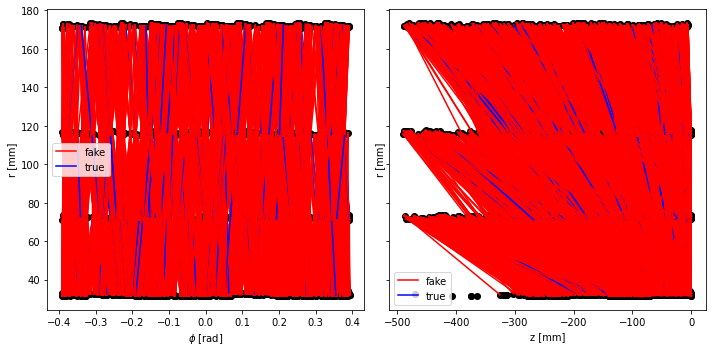

In [8]:
plot_cylindrical(graphs, n_section=8)

In [13]:
def plot_3d(graphs,n_section,make_gif=False):

    def change_view(az=20):
        ax.view_init(elev=10, azim=az%360)
        return ax 

    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    cmap = plt.get_cmap('bwr_r')
    theta_counter = np.pi/n_section # start 45 degree rotated
    for i in range(len(graphs)):
        # print('Plotting file: ' + filenames[i])
        # X, Ri, Ro, y = load_graph(filenames[i])
        X, Ri, Ro, y = graphs[i]
        X[:,1] = X[:,1] * np.pi/n_section
        theta = (X[:,1] + theta_counter)%(np.pi*2)
           
        ax.scatter(1000*X[:,2],1000*X[:,0]*np.cos(theta), 1000*X[:,0]*np.sin(theta), c='k',s=1)

        feats_o = X[np.where(Ri.T)[1]]
        feats_i = X[np.where(Ro.T)[1]]

        x_o = 1000*feats_o[:,0]*np.cos(feats_o[:,1]+theta_counter)
        x_i = 1000*feats_i[:,0]*np.cos(feats_i[:,1]+theta_counter)
        y_o = 1000*feats_o[:,0]*np.sin(feats_o[:,1]+theta_counter)
        y_i = 1000*feats_i[:,0]*np.sin(feats_i[:,1]+theta_counter)
        z_o = 1000*feats_o[:,2]
        z_i = 1000*feats_i[:,2]
        
        for j in range(y.shape[0]):
            seg_args = dict(c='C'+str(i), alpha=float(y[j]))
            ax.plot([z_o[j],z_i[j]],[x_o[j],x_i[j]],[y_o[j],y_i[j]],'-', **seg_args)
        
        if i%2==1:
            theta_counter += 2*np.pi/n_section
            theta_counter = theta_counter%(np.pi*2)
        
    ax.set_xlabel('$Z [mm]$')
    ax.set_ylabel('$X [mm]$')  
    ax.set_zlabel('$Y [mm]$') 
    ax.grid(b=None)
    change_view(45)
    ax.dist = 8 
    plt.savefig('Cartesian3D.pdf')
    plt.savefig('Cartesian3D.png')
    if make_gif == True:
        # Make Gif
        rotation_angle = 360  # total rotation angle in degrees
        duration = 	5 # duration of gif in seconds
        anim = FuncAnimation(fig, change_view, frames=np.arange(0, rotation_angle), interval=duration*1000/rotation_angle)
        anim.save('Cartesian3D.gif', dpi=80, writer='PillowWriter')  

In [ ]:
plot_3d(graphs, n_section=8, make_gif=True)

C:\Users\amir\AppData\Local\Temp\ipykernel_32072\1452741381.py:41: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)
